In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!mkdir drive/MyDrive/long_landsat
!ls drive/MyDrive/long_landsat

best_model_swinir_l7_l5_nir.pth  best_model_swinir_l7_l9_red.pth  l7_nir_2000.nc  l7_red.nc
best_model_swinir_l7_l5_red.pth  l5_nir_2000.nc			  l7_nir.nc	  l9_nir.nc
best_model_swinir_l7_l9_nir.pth  l5_red_2000.nc			  l7_red_2000.nc  l9_red.nc


In [ ]:
import ee
ee.Authenticate()
ee.Initialize(project= "ee-manmeet20singh15-wbis")

In [ ]:
!pip install timm
!pip install wxee

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.

In [ ]:
!pip install tqdm

In [ ]:
import ee
import wxee
wxee.Initialize()
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize
from PIL import Image
import os
import numpy as np
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.checkpoint as checkpoint
from timm.models.layers import DropPath, to_2tuple, trunc_normal_
import numpy as np
import xarray as xr

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor, Resize
from PIL import Image
import os
import numpy as np
from torch.utils.tensorboard import SummaryWriter

# Swin Transformer

https://arxiv.org/pdf/2103.14030.pdf

In [ ]:
def train(model, train_dataloader, val_dataloader, criterion, optimizer, device):
    model.train()
    train_loss = 0.0
    for batch in train_dataloader:
        lr, hr = batch
        lr, hr = lr.to(device), hr.to(device)
        optimizer.zero_grad()
        sr = model(lr)
        loss = criterion(sr, hr)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_dataloader)

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_dataloader:
            lr, hr = batch
            lr, hr = lr.to(device), hr.to(device)
            sr = model(lr)
            loss = criterion(sr, hr)
            val_loss += loss.item()

    val_loss /= len(val_dataloader)

    return train_loss, val_loss

class Mlp(nn.Module):
    def __init__(self, in_features, hidden_features=None, out_features=None, act_layer=nn.GELU, drop=0.):
        super().__init__()
        out_features = out_features or in_features
        hidden_features = hidden_features or in_features
        self.fc1 = nn.Linear(in_features, hidden_features)
        self.act = act_layer()
        self.fc2 = nn.Linear(hidden_features, out_features)
        self.drop = nn.Dropout(drop)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.drop(x)
        x = self.fc2(x)
        x = self.drop(x)
        return x


def window_partition(x, window_size):
    """
    Args:
        x: (B, H, W, C)
        window_size (int): window size
    Returns:
        windows: (num_windows*B, window_size, window_size, C)
    """
    B, H, W, C = x.shape
    x = x.view(B, H // window_size, window_size, W // window_size, window_size, C)
    windows = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(-1, window_size, window_size, C)
    return windows


def window_reverse(windows, window_size, H, W):
    """
    Args:
        windows: (num_windows*B, window_size, window_size, C)
        window_size (int): Window size
        H (int): Height of image
        W (int): Width of image
    Returns:
        x: (B, H, W, C)
    """
    B = int(windows.shape[0] / (H * W / window_size / window_size))
    x = windows.view(B, H // window_size, W // window_size, window_size, window_size, -1)
    x = x.permute(0, 1, 3, 2, 4, 5).contiguous().view(B, H, W, -1)
    return x


class WindowAttention(nn.Module):
    r""" Window based multi-head self attention (W-MSA) module with relative position bias.
    It supports both of shifted and non-shifted window.
    Args:
        dim (int): Number of input channels.
        window_size (tuple[int]): The height and width of the window.
        num_heads (int): Number of attention heads.
        qkv_bias (bool, optional):  If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set
        attn_drop (float, optional): Dropout ratio of attention weight. Default: 0.0
        proj_drop (float, optional): Dropout ratio of output. Default: 0.0
    """

    def __init__(self, dim, window_size, num_heads, qkv_bias=True, qk_scale=None, attn_drop=0., proj_drop=0.):

        super().__init__()
        self.dim = dim
        self.window_size = window_size  # Wh, Ww
        self.num_heads = num_heads
        head_dim = dim // num_heads
        self.scale = qk_scale or head_dim ** -0.5

        # define a parameter table of relative position bias
        self.relative_position_bias_table = nn.Parameter(
            torch.zeros((2 * window_size[0] - 1) * (2 * window_size[1] - 1), num_heads))  # 2*Wh-1 * 2*Ww-1, nH

        # get pair-wise relative position index for each token inside the window
        coords_h = torch.arange(self.window_size[0])
        coords_w = torch.arange(self.window_size[1])
        coords = torch.stack(torch.meshgrid([coords_h, coords_w]))  # 2, Wh, Ww
        coords_flatten = torch.flatten(coords, 1)  # 2, Wh*Ww
        relative_coords = coords_flatten[:, :, None] - coords_flatten[:, None, :]  # 2, Wh*Ww, Wh*Ww
        relative_coords = relative_coords.permute(1, 2, 0).contiguous()  # Wh*Ww, Wh*Ww, 2
        relative_coords[:, :, 0] += self.window_size[0] - 1  # shift to start from 0
        relative_coords[:, :, 1] += self.window_size[1] - 1
        relative_coords[:, :, 0] *= 2 * self.window_size[1] - 1
        relative_position_index = relative_coords.sum(-1)  # Wh*Ww, Wh*Ww
        self.register_buffer("relative_position_index", relative_position_index)

        self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)

        self.proj_drop = nn.Dropout(proj_drop)

        trunc_normal_(self.relative_position_bias_table, std=.02)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x, mask=None):
        """
        Args:
            x: input features with shape of (num_windows*B, N, C)
            mask: (0/-inf) mask with shape of (num_windows, Wh*Ww, Wh*Ww) or None
        """
        B_, N, C = x.shape
        qkv = self.qkv(x).reshape(B_, N, 3, self.num_heads, C // self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]  # make torchscript happy (cannot use tensor as tuple)

        q = q * self.scale
        attn = (q @ k.transpose(-2, -1))

        relative_position_bias = self.relative_position_bias_table[self.relative_position_index.view(-1)].view(
            self.window_size[0] * self.window_size[1], self.window_size[0] * self.window_size[1], -1)  # Wh*Ww,Wh*Ww,nH
        relative_position_bias = relative_position_bias.permute(2, 0, 1).contiguous()  # nH, Wh*Ww, Wh*Ww
        attn = attn + relative_position_bias.unsqueeze(0)

        if mask is not None:
            nW = mask.shape[0]
            attn = attn.view(B_ // nW, nW, self.num_heads, N, N) + mask.unsqueeze(1).unsqueeze(0)
            attn = attn.view(-1, self.num_heads, N, N)
            attn = self.softmax(attn)
        else:
            attn = self.softmax(attn)

        attn = self.attn_drop(attn)

        x = (attn @ v).transpose(1, 2).reshape(B_, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        return x

    def extra_repr(self) -> str:
        return f'dim={self.dim}, window_size={self.window_size}, num_heads={self.num_heads}'

    def flops(self, N):
        # calculate flops for 1 window with token length of N
        flops = 0
        # qkv = self.qkv(x)
        flops += N * self.dim * 3 * self.dim
        # attn = (q @ k.transpose(-2, -1))
        flops += self.num_heads * N * (self.dim // self.num_heads) * N
        #  x = (attn @ v)
        flops += self.num_heads * N * N * (self.dim // self.num_heads)
        # x = self.proj(x)
        flops += N * self.dim * self.dim
        return flops


class SwinTransformerBlock(nn.Module):
    r""" Swin Transformer Block.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resulotion.
        num_heads (int): Number of attention heads.
        window_size (int): Window size.
        shift_size (int): Shift size for SW-MSA.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float, optional): Stochastic depth rate. Default: 0.0
        act_layer (nn.Module, optional): Activation layer. Default: nn.GELU
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, dim, input_resolution, num_heads, window_size=7, shift_size=0,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0., drop_path=0.,
                 act_layer=nn.GELU, norm_layer=nn.LayerNorm):
        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.num_heads = num_heads
        self.window_size = window_size
        self.shift_size = shift_size
        self.mlp_ratio = mlp_ratio
        if min(self.input_resolution) <= self.window_size:
            # if window size is larger than input resolution, we don't partition windows
            self.shift_size = 0
            self.window_size = min(self.input_resolution)
        assert 0 <= self.shift_size < self.window_size, "shift_size must in 0-window_size"

        self.norm1 = norm_layer(dim)
        self.attn = WindowAttention(
            dim, window_size=to_2tuple(self.window_size), num_heads=num_heads,
            qkv_bias=qkv_bias, qk_scale=qk_scale, attn_drop=attn_drop, proj_drop=drop)

        self.drop_path = DropPath(drop_path) if drop_path > 0. else nn.Identity()
        self.norm2 = norm_layer(dim)
        mlp_hidden_dim = int(dim * mlp_ratio)
        self.mlp = Mlp(in_features=dim, hidden_features=mlp_hidden_dim, act_layer=act_layer, drop=drop)

        if self.shift_size > 0:
            attn_mask = self.calculate_mask(self.input_resolution)
        else:
            attn_mask = None

        self.register_buffer("attn_mask", attn_mask)

    def calculate_mask(self, x_size):
        # calculate attention mask for SW-MSA
        H, W = x_size
        img_mask = torch.zeros((1, H, W, 1))  # 1 H W 1
        h_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        w_slices = (slice(0, -self.window_size),
                    slice(-self.window_size, -self.shift_size),
                    slice(-self.shift_size, None))
        cnt = 0
        for h in h_slices:
            for w in w_slices:
                img_mask[:, h, w, :] = cnt
                cnt += 1

        mask_windows = window_partition(img_mask, self.window_size)  # nW, window_size, window_size, 1
        mask_windows = mask_windows.view(-1, self.window_size * self.window_size)
        attn_mask = mask_windows.unsqueeze(1) - mask_windows.unsqueeze(2)
        attn_mask = attn_mask.masked_fill(attn_mask != 0, float(-100.0)).masked_fill(attn_mask == 0, float(0.0))

        return attn_mask

    def forward(self, x, x_size):
        H, W = x_size
        B, L, C = x.shape
        # assert L == H * W, "input feature has wrong size"

        shortcut = x
        x = self.norm1(x)
        x = x.view(B, H, W, C)

        # cyclic shift
        if self.shift_size > 0:
            shifted_x = torch.roll(x, shifts=(-self.shift_size, -self.shift_size), dims=(1, 2))
        else:
            shifted_x = x

        # partition windows
        x_windows = window_partition(shifted_x, self.window_size)  # nW*B, window_size, window_size, C
        x_windows = x_windows.view(-1, self.window_size * self.window_size, C)  # nW*B, window_size*window_size, C

        # W-MSA/SW-MSA (to be compatible for testing on images whose shapes are the multiple of window size
        if self.input_resolution == x_size:
            attn_windows = self.attn(x_windows, mask=self.attn_mask)  # nW*B, window_size*window_size, C
        else:
            attn_windows = self.attn(x_windows, mask=self.calculate_mask(x_size).to(x.device))

        # merge windows
        attn_windows = attn_windows.view(-1, self.window_size, self.window_size, C)
        shifted_x = window_reverse(attn_windows, self.window_size, H, W)  # B H' W' C

        # reverse cyclic shift
        if self.shift_size > 0:
            x = torch.roll(shifted_x, shifts=(self.shift_size, self.shift_size), dims=(1, 2))
        else:
            x = shifted_x
        x = x.view(B, H * W, C)

        # FFN
        x = shortcut + self.drop_path(x)
        x = x + self.drop_path(self.mlp(self.norm2(x)))

        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, num_heads={self.num_heads}, " \
               f"window_size={self.window_size}, shift_size={self.shift_size}, mlp_ratio={self.mlp_ratio}"

    def flops(self):
        flops = 0
        H, W = self.input_resolution
        # norm1
        flops += self.dim * H * W
        # W-MSA/SW-MSA
        nW = H * W / self.window_size / self.window_size
        flops += nW * self.attn.flops(self.window_size * self.window_size)
        # mlp
        flops += 2 * H * W * self.dim * self.dim * self.mlp_ratio
        # norm2
        flops += self.dim * H * W
        return flops


class PatchMerging(nn.Module):
    r""" Patch Merging Layer.
    Args:
        input_resolution (tuple[int]): Resolution of input feature.
        dim (int): Number of input channels.
        norm_layer (nn.Module, optional): Normalization layer.  Default: nn.LayerNorm
    """

    def __init__(self, input_resolution, dim, norm_layer=nn.LayerNorm):
        super().__init__()
        self.input_resolution = input_resolution
        self.dim = dim
        self.reduction = nn.Linear(4 * dim, 2 * dim, bias=False)
        self.norm = norm_layer(4 * dim)

    def forward(self, x):
        """
        x: B, H*W, C
        """
        H, W = self.input_resolution
        B, L, C = x.shape
        assert L == H * W, "input feature has wrong size"
        assert H % 2 == 0 and W % 2 == 0, f"x size ({H}*{W}) are not even."

        x = x.view(B, H, W, C)

        x0 = x[:, 0::2, 0::2, :]  # B H/2 W/2 C
        x1 = x[:, 1::2, 0::2, :]  # B H/2 W/2 C
        x2 = x[:, 0::2, 1::2, :]  # B H/2 W/2 C
        x3 = x[:, 1::2, 1::2, :]  # B H/2 W/2 C
        x = torch.cat([x0, x1, x2, x3], -1)  # B H/2 W/2 4*C
        x = x.view(B, -1, 4 * C)  # B H/2*W/2 4*C

        x = self.norm(x)
        x = self.reduction(x)

        return x

    def extra_repr(self) -> str:
        return f"input_resolution={self.input_resolution}, dim={self.dim}"

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.dim
        flops += (H // 2) * (W // 2) * 4 * self.dim * 2 * self.dim
        return flops


class BasicLayer(nn.Module):
    """ A basic Swin Transformer layer for one stage.
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False):

        super().__init__()
        self.dim = dim
        self.input_resolution = input_resolution
        self.depth = depth
        self.use_checkpoint = use_checkpoint

        # build blocks
        self.blocks = nn.ModuleList([
            SwinTransformerBlock(dim=dim, input_resolution=input_resolution,
                                 num_heads=num_heads, window_size=window_size,
                                 shift_size=0 if (i % 2 == 0) else window_size // 2,
                                 mlp_ratio=mlp_ratio,
                                 qkv_bias=qkv_bias, qk_scale=qk_scale,
                                 drop=drop, attn_drop=attn_drop,
                                 drop_path=drop_path[i] if isinstance(drop_path, list) else drop_path,
                                 norm_layer=norm_layer)
            for i in range(depth)])

        # patch merging layer
        if downsample is not None:
            self.downsample = downsample(input_resolution, dim=dim, norm_layer=norm_layer)
        else:
            self.downsample = None

    def forward(self, x, x_size):
        for blk in self.blocks:
            if self.use_checkpoint:
                x = checkpoint.checkpoint(blk, x, x_size)
            else:
                x = blk(x, x_size)
        if self.downsample is not None:
            x = self.downsample(x)
        return x

    def extra_repr(self) -> str:
        return f"dim={self.dim}, input_resolution={self.input_resolution}, depth={self.depth}"

    def flops(self):
        flops = 0
        for blk in self.blocks:
            flops += blk.flops()
        if self.downsample is not None:
            flops += self.downsample.flops()
        return flops


class RSTB(nn.Module):
    """Residual Swin Transformer Block (RSTB).
    Args:
        dim (int): Number of input channels.
        input_resolution (tuple[int]): Input resolution.
        depth (int): Number of blocks.
        num_heads (int): Number of attention heads.
        window_size (int): Local window size.
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim.
        qkv_bias (bool, optional): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float | None, optional): Override default qk scale of head_dim ** -0.5 if set.
        drop (float, optional): Dropout rate. Default: 0.0
        attn_drop (float, optional): Attention dropout rate. Default: 0.0
        drop_path (float | tuple[float], optional): Stochastic depth rate. Default: 0.0
        norm_layer (nn.Module, optional): Normalization layer. Default: nn.LayerNorm
        downsample (nn.Module | None, optional): Downsample layer at the end of the layer. Default: None
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False.
        img_size: Input image size.
        patch_size: Patch size.
        resi_connection: The convolutional block before residual connection.
    """

    def __init__(self, dim, input_resolution, depth, num_heads, window_size,
                 mlp_ratio=4., qkv_bias=True, qk_scale=None, drop=0., attn_drop=0.,
                 drop_path=0., norm_layer=nn.LayerNorm, downsample=None, use_checkpoint=False,
                 img_size=224, patch_size=4, resi_connection='1conv'):
        super(RSTB, self).__init__()

        self.dim = dim
        self.input_resolution = input_resolution

        self.residual_group = BasicLayer(dim=dim,
                                         input_resolution=input_resolution,
                                         depth=depth,
                                         num_heads=num_heads,
                                         window_size=window_size,
                                         mlp_ratio=mlp_ratio,
                                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                                         drop=drop, attn_drop=attn_drop,
                                         drop_path=drop_path,
                                         norm_layer=norm_layer,
                                         downsample=downsample,
                                         use_checkpoint=use_checkpoint)

        if resi_connection == '1conv':
            self.conv = nn.Conv2d(dim, dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv = nn.Sequential(nn.Conv2d(dim, dim // 4, 3, 1, 1), nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim // 4, 1, 1, 0),
                                      nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                      nn.Conv2d(dim // 4, dim, 3, 1, 1))

        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=0, embed_dim=dim,
            norm_layer=None)

    def forward(self, x, x_size):
        return self.patch_embed(self.conv(self.patch_unembed(self.residual_group(x, x_size), x_size))) + x

    def flops(self):
        flops = 0
        flops += self.residual_group.flops()
        H, W = self.input_resolution
        flops += H * W * self.dim * self.dim * 9
        flops += self.patch_embed.flops()
        flops += self.patch_unembed.flops()

        return flops


class PatchEmbed(nn.Module):
    r""" Image to Patch Embedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

        if norm_layer is not None:
            self.norm = norm_layer(embed_dim)
        else:
            self.norm = None

    def forward(self, x):
        x = x.flatten(2).transpose(1, 2)  # B Ph*Pw C
        if self.norm is not None:
            x = self.norm(x)
        return x

    def flops(self):
        flops = 0
        H, W = self.img_size
        if self.norm is not None:
            flops += H * W * self.embed_dim
        return flops


class PatchUnEmbed(nn.Module):
    r""" Image to Patch Unembedding
    Args:
        img_size (int): Image size.  Default: 224.
        patch_size (int): Patch token size. Default: 4.
        in_chans (int): Number of input image channels. Default: 3.
        embed_dim (int): Number of linear projection output channels. Default: 96.
        norm_layer (nn.Module, optional): Normalization layer. Default: None
    """

    def __init__(self, img_size=224, patch_size=4, in_chans=3, embed_dim=96, norm_layer=None):
        super().__init__()
        img_size = to_2tuple(img_size)
        patch_size = to_2tuple(patch_size)
        patches_resolution = [img_size[0] // patch_size[0], img_size[1] // patch_size[1]]
        self.img_size = img_size
        self.patch_size = patch_size
        self.patches_resolution = patches_resolution
        self.num_patches = patches_resolution[0] * patches_resolution[1]

        self.in_chans = in_chans
        self.embed_dim = embed_dim

    def forward(self, x, x_size):
        B, HW, C = x.shape
        x = x.transpose(1, 2).view(B, self.embed_dim, x_size[0], x_size[1])  # B Ph*Pw C
        return x

    def flops(self):
        flops = 0
        return flops


class Upsample(nn.Sequential):
    """Upsample module.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat):
        m = []
        if (scale & (scale - 1)) == 0:  # scale = 2^n
            for _ in range(int(math.log(scale, 2))):
                m.append(nn.Conv2d(num_feat, 4 * num_feat, 3, 1, 1))
                m.append(nn.PixelShuffle(2))
        elif scale == 3:
            m.append(nn.Conv2d(num_feat, 9 * num_feat, 3, 1, 1))
            m.append(nn.PixelShuffle(3))
        else:
            raise ValueError(f'scale {scale} is not supported. ' 'Supported scales: 2^n and 3.')
        super(Upsample, self).__init__(*m)


class UpsampleOneStep(nn.Sequential):
    """UpsampleOneStep module (the difference with Upsample is that it always only has 1conv + 1pixelshuffle)
       Used in lightweight SR to save parameters.
    Args:
        scale (int): Scale factor. Supported scales: 2^n and 3.
        num_feat (int): Channel number of intermediate features.
    """

    def __init__(self, scale, num_feat, num_out_ch, input_resolution=None):
        self.num_feat = num_feat
        self.input_resolution = input_resolution
        m = []
        m.append(nn.Conv2d(num_feat, (scale ** 2) * num_out_ch, 3, 1, 1))
        m.append(nn.PixelShuffle(scale))
        super(UpsampleOneStep, self).__init__(*m)

    def flops(self):
        H, W = self.input_resolution
        flops = H * W * self.num_feat * 3 * 9
        return flops


class SwinIR(nn.Module):
    r""" SwinIR
        A PyTorch impl of : `SwinIR: Image Restoration Using Swin Transformer`, based on Swin Transformer.
    Args:
        img_size (int | tuple(int)): Input image size. Default 64
        patch_size (int | tuple(int)): Patch size. Default: 1
        in_chans (int): Number of input image channels. Default: 3
        embed_dim (int): Patch embedding dimension. Default: 96
        depths (tuple(int)): Depth of each Swin Transformer layer.
        num_heads (tuple(int)): Number of attention heads in different layers.
        window_size (int): Window size. Default: 7
        mlp_ratio (float): Ratio of mlp hidden dim to embedding dim. Default: 4
        qkv_bias (bool): If True, add a learnable bias to query, key, value. Default: True
        qk_scale (float): Override default qk scale of head_dim ** -0.5 if set. Default: None
        drop_rate (float): Dropout rate. Default: 0
        attn_drop_rate (float): Attention dropout rate. Default: 0
        drop_path_rate (float): Stochastic depth rate. Default: 0.1
        norm_layer (nn.Module): Normalization layer. Default: nn.LayerNorm.
        ape (bool): If True, add absolute position embedding to the patch embedding. Default: False
        patch_norm (bool): If True, add normalization after patch embedding. Default: True
        use_checkpoint (bool): Whether to use checkpointing to save memory. Default: False
        upscale: Upscale factor. 2/3/4/8 for image SR, 1 for denoising and compress artifact reduction
        img_range: Image range. 1. or 255.
        upsampler: The reconstruction reconstruction module. 'pixelshuffle'/'pixelshuffledirect'/'nearest+conv'/None
        resi_connection: The convolutional block before residual connection. '1conv'/'3conv'
    """

    def __init__(self, img_size=64, patch_size=1, in_chans=1,
                 embed_dim=96, depths=[6, 6, 6, 6], num_heads=[6, 6, 6, 6],
                 window_size=7, mlp_ratio=4., qkv_bias=True, qk_scale=None,
                 drop_rate=0., attn_drop_rate=0., drop_path_rate=0.1,
                 norm_layer=nn.LayerNorm, ape=False, patch_norm=True,
                 use_checkpoint=False, upscale=1, img_range=1., upsampler='', resi_connection='1conv',
                 **kwargs):
        super(SwinIR, self).__init__()
        num_in_ch = in_chans
        num_out_ch = in_chans
        num_feat = 64
        self.img_range = img_range
        if in_chans == 3:
            rgb_mean = (0.4488, 0.4371, 0.4040)
            self.mean = torch.Tensor(rgb_mean).view(1, 3, 1, 1)
        else:
            self.mean = torch.zeros(1, 1, 1, 1)
        self.upscale = upscale
        self.upsampler = upsampler
        self.window_size = window_size

        #####################################################################################################
        ################################### 1, shallow feature extraction ###################################
        self.conv_first = nn.Conv2d(num_in_ch, embed_dim, 3, 1, 1)

        #####################################################################################################
        ################################### 2, deep feature extraction ######################################
        self.num_layers = len(depths)
        self.embed_dim = embed_dim
        self.ape = ape
        self.patch_norm = patch_norm
        self.num_features = embed_dim
        self.mlp_ratio = mlp_ratio

        # split image into non-overlapping patches
        self.patch_embed = PatchEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)
        num_patches = self.patch_embed.num_patches
        patches_resolution = self.patch_embed.patches_resolution
        self.patches_resolution = patches_resolution

        # merge non-overlapping patches into image
        self.patch_unembed = PatchUnEmbed(
            img_size=img_size, patch_size=patch_size, in_chans=embed_dim, embed_dim=embed_dim,
            norm_layer=norm_layer if self.patch_norm else None)

        # absolute position embedding
        if self.ape:
            self.absolute_pos_embed = nn.Parameter(torch.zeros(1, num_patches, embed_dim))
            trunc_normal_(self.absolute_pos_embed, std=.02)

        self.pos_drop = nn.Dropout(p=drop_rate)

        # stochastic depth
        dpr = [x.item() for x in torch.linspace(0, drop_path_rate, sum(depths))]  # stochastic depth decay rule

        # build Residual Swin Transformer blocks (RSTB)
        self.layers = nn.ModuleList()
        for i_layer in range(self.num_layers):
            layer = RSTB(dim=embed_dim,
                         input_resolution=(patches_resolution[0],
                                           patches_resolution[1]),
                         depth=depths[i_layer],
                         num_heads=num_heads[i_layer],
                         window_size=window_size,
                         mlp_ratio=self.mlp_ratio,
                         qkv_bias=qkv_bias, qk_scale=qk_scale,
                         drop=drop_rate, attn_drop=attn_drop_rate,
                         drop_path=dpr[sum(depths[:i_layer]):sum(depths[:i_layer + 1])],  # no impact on SR results
                         norm_layer=norm_layer,
                         downsample=None,
                         use_checkpoint=use_checkpoint,
                         img_size=img_size,
                         patch_size=patch_size,
                         resi_connection=resi_connection

                         )
            self.layers.append(layer)
        self.norm = norm_layer(self.num_features)

        # build the last conv layer in deep feature extraction
        if resi_connection == '1conv':
            self.conv_after_body = nn.Conv2d(embed_dim, embed_dim, 3, 1, 1)
        elif resi_connection == '3conv':
            # to save parameters and memory
            self.conv_after_body = nn.Sequential(nn.Conv2d(embed_dim, embed_dim // 4, 3, 1, 1),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim // 4, 1, 1, 0),
                                                 nn.LeakyReLU(negative_slope=0.2, inplace=True),
                                                 nn.Conv2d(embed_dim // 4, embed_dim, 3, 1, 1))

        #####################################################################################################
        ################################ 3, high quality image reconstruction ################################
        if self.upsampler == 'pixelshuffle':
            # for classical SR
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.upsample = Upsample(upscale, num_feat)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR (to save parameters)
            self.upsample = UpsampleOneStep(upscale, embed_dim, num_out_ch,
                                            (patches_resolution[0], patches_resolution[1]))
        elif self.upsampler == 'nearest+conv':
            # for real-world SR (less artifacts)
            self.conv_before_upsample = nn.Sequential(nn.Conv2d(embed_dim, num_feat, 3, 1, 1),
                                                      nn.LeakyReLU(inplace=True))
            self.conv_up1 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            if self.upscale == 4:
                self.conv_up2 = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_hr = nn.Conv2d(num_feat, num_feat, 3, 1, 1)
            self.conv_last = nn.Conv2d(num_feat, num_out_ch, 3, 1, 1)
            self.lrelu = nn.LeakyReLU(negative_slope=0.2, inplace=True)
        else:
            # for image denoising and JPEG compression artifact reduction
            self.conv_last = nn.Conv2d(embed_dim, num_out_ch, 3, 1, 1)

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            trunc_normal_(m.weight, std=.02)
            if isinstance(m, nn.Linear) and m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.LayerNorm):
            nn.init.constant_(m.bias, 0)
            nn.init.constant_(m.weight, 1.0)

    @torch.jit.ignore
    def no_weight_decay(self):
        return {'absolute_pos_embed'}

    @torch.jit.ignore
    def no_weight_decay_keywords(self):
        return {'relative_position_bias_table'}

    def check_image_size(self, x):
        _, _, h, w = x.size()
        mod_pad_h = (self.window_size - h % self.window_size) % self.window_size
        mod_pad_w = (self.window_size - w % self.window_size) % self.window_size
        x = F.pad(x, (0, mod_pad_w, 0, mod_pad_h), 'reflect')
        return x

    def forward_features(self, x):
        x_size = (x.shape[2], x.shape[3])
        x = self.patch_embed(x)
        if self.ape:
            x = x + self.absolute_pos_embed
        x = self.pos_drop(x)

        for layer in self.layers:
            x = layer(x, x_size)

        x = self.norm(x)  # B L C
        x = self.patch_unembed(x, x_size)

        return x

    def forward(self, x):
        H, W = x.shape[2:]
        x = self.check_image_size(x)

        self.mean = self.mean.type_as(x)
        x = (x - self.mean) * self.img_range

        if self.upsampler == 'pixelshuffle':
            # for classical SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.conv_last(self.upsample(x))
        elif self.upsampler == 'pixelshuffledirect':
            # for lightweight SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.upsample(x)
        elif self.upsampler == 'nearest+conv':
            # for real-world SR
            x = self.conv_first(x)
            x = self.conv_after_body(self.forward_features(x)) + x
            x = self.conv_before_upsample(x)
            x = self.lrelu(self.conv_up1(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            if self.upscale == 4:
                x = self.lrelu(self.conv_up2(torch.nn.functional.interpolate(x, scale_factor=2, mode='nearest')))
            x = self.conv_last(self.lrelu(self.conv_hr(x)))
        else:
            # for image denoising and JPEG compression artifact reduction
            x_first = self.conv_first(x)
            res = self.conv_after_body(self.forward_features(x_first)) + x_first
            x = x + self.conv_last(res)

        x = x / self.img_range + self.mean

        return x[:, :, :H*self.upscale, :W*self.upscale]

    def flops(self):
        flops = 0
        H, W = self.patches_resolution
        flops += H * W * 3 * self.embed_dim * 9
        flops += self.patch_embed.flops()
        for i, layer in enumerate(self.layers):
            flops += layer.flops()
        flops += H * W * 3 * self.embed_dim * self.embed_dim
        flops += self.upsample.flops()
        return flops
upscale = 1
window_size = 5
height = 30 #(1024 // upscale // window_size + 1) * window_size
width = 30 #(720 // upscale // window_size + 1) * window_size
device = 'cuda'
model = SwinIR(upscale=1, img_size=(height, width),
               window_size=window_size, img_range=1., depths=[6, 6, 6, 6],
               embed_dim=60, num_heads=[6, 6, 6, 6], mlp_ratio=2, upsampler='pixelshuffledirect').to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Landsat-9 TOA

LANDSAT/LC09/C02/T1_TOA

B5	30 meters	0.85 - 0.88 μm	 Near infrared

B4	30 meters	0.64 - 0.67 μm	 Red

Availability: 2021-10-31T00:00:00Z–present

# Landsat-7 TOA

LE7_L1T_TOA

B3	30 meters	0.63 - 0.69 μm	 Red

B4	30 meters	0.77 - 0.90 μm	 Near infrared

Availability: 1999-05-28T01:02:17Z–present

Common year: 2022

In [ ]:
L5_red_2000 = ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA').filterDate('2000-01-01', '2000-12-31').select('B3').mean()
L5_nir_2000 = ee.ImageCollection('LANDSAT/LT05/C02/T1_TOA').filterDate('2000-01-01', '2000-12-31').select('B4').mean()

L7_red_2000 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('2000-01-01', '2000-12-31').select('B3').mean()
L7_nir_2000 = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('2000-01-01', '2000-12-31').select('B4').mean()

L7_red = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('2022-01-01', '2022-12-31').select('B3').mean()
L7_nir = ee.ImageCollection('LANDSAT/LE07/C02/T1_TOA').filterDate('2022-01-01', '2022-12-31').select('B4').mean()

L9_red = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA').filterDate('2022-01-01', '2022-12-31').select('B4').mean()
L9_nir = ee.ImageCollection('LANDSAT/LC09/C02/T1_TOA').filterDate('2022-01-01', '2022-12-31').select('B5').mean()

In [ ]:
lats, late = 30.2672-0.25, 30.2672+0.25
lons, lone = -97.7431-0.25, -97.7431+0.25
aoi = ee.Geometry.Polygon(
        [[[lons, lats],
          [lone, lats],
          [lone, late],
          [lons, late]]])
coords = aoi.coordinates().getInfo()[0]

In [ ]:
import ee
import wxee
wxee.Initialize()

In [ ]:
mosaic = L5_red_2000.set('system:time_start', 0)
ds_l5_red_2000 = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L5_nir_2000.set('system:time_start', 0)
ds_l5_nir_2000 = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L7_red_2000.set('system:time_start', 0)
ds_l7_red_2000 = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L7_nir_2000.set('system:time_start', 0)
ds_l7_nir_2000 = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L7_red.set('system:time_start', 0)
ds_l7_red = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L7_nir.set('system:time_start', 0)
ds_l7_nir = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L9_red.set('system:time_start', 0)
ds_l9_red = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

mosaic = L9_nir.set('system:time_start', 0)
ds_l9_nir = mosaic.wx.to_xarray(region=aoi.bounds(), scale=30)

Downloading:   0%|          | 0.00/9.91M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.81M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.85M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.80M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/10.1M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.88M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.92M [00:00<?, ?iB/s]

Downloading:   0%|          | 0.00/9.83M [00:00<?, ?iB/s]

In [ ]:
ds_l5_red_2000.to_netcdf('l5_red_2000.nc')
ds_l5_nir_2000.to_netcdf('l5_nir_2000.nc')
ds_l7_red_2000.to_netcdf('l7_red_2000.nc')
ds_l7_nir_2000.to_netcdf('l7_nir_2000.nc')
ds_l7_red.to_netcdf('l7_red.nc')
ds_l7_nir.to_netcdf('l7_nir.nc')
ds_l9_red.to_netcdf('l9_red.nc')
ds_l9_nir.to_netcdf('l9_nir.nc')

In [ ]:
#!mv *.nc /content/drive/MyDrive/long_landsat

In [ ]:
!ls /content/drive/MyDrive/long_landsat

best_model_swinir_l7_l5_nir.pth  best_model_swinir_l7_l9_red.pth  l7_nir_2000.nc  l7_red.nc
best_model_swinir_l7_l5_red.pth  l5_nir_2000.nc			  l7_nir.nc	  l9_nir.nc
best_model_swinir_l7_l9_nir.pth  l5_red_2000.nc			  l7_red_2000.nc  l9_red.nc


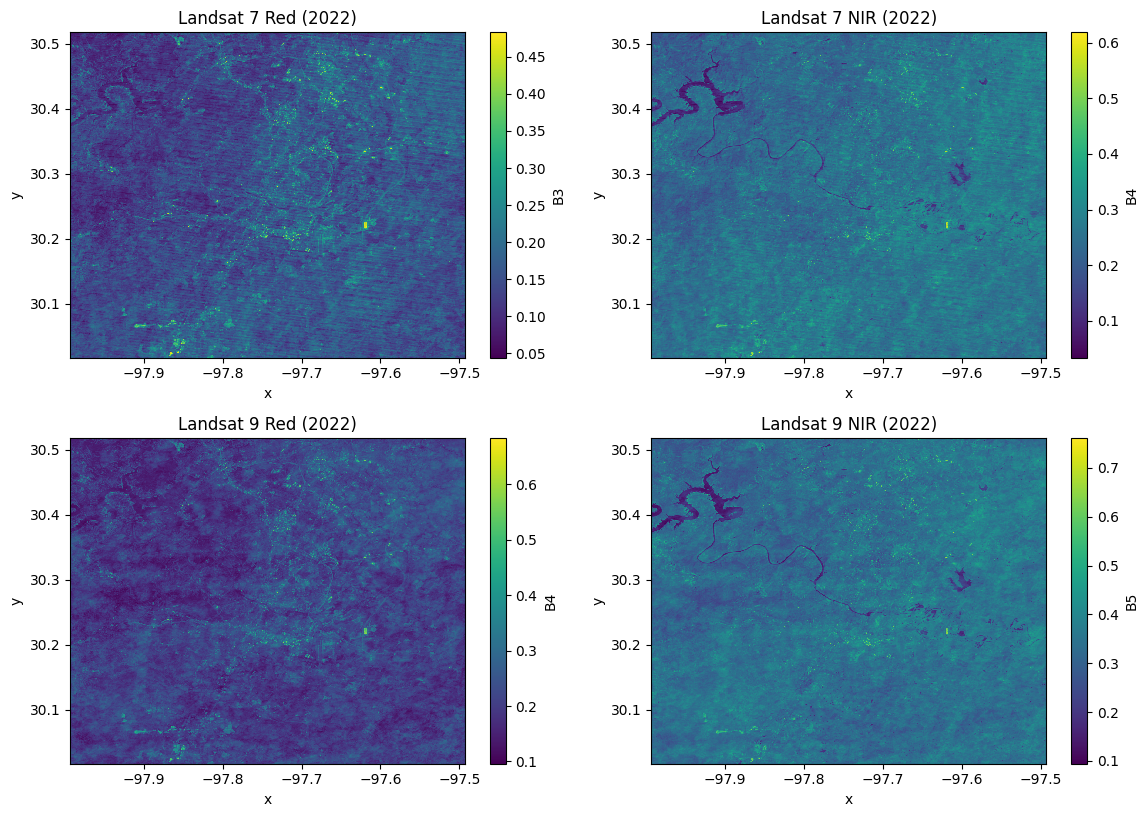

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=2,nrows=2, figsize=(11.69,8.27))
ds_l7_red.B3.plot(ax=ax[0,0])
ds_l7_nir.B4.plot(ax=ax[0,1])
ds_l9_red.B4.plot(ax=ax[1,0])
ds_l9_nir.B5.plot(ax=ax[1,1])
titles = ['Landsat 7 Red (2022)', 'Landsat 7 NIR (2022)', 'Landsat 9 Red (2022)', 'Landsat 9 NIR (2022)']
cnt = 0
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(titles[cnt])
        cnt = cnt + 1
plt.tight_layout()

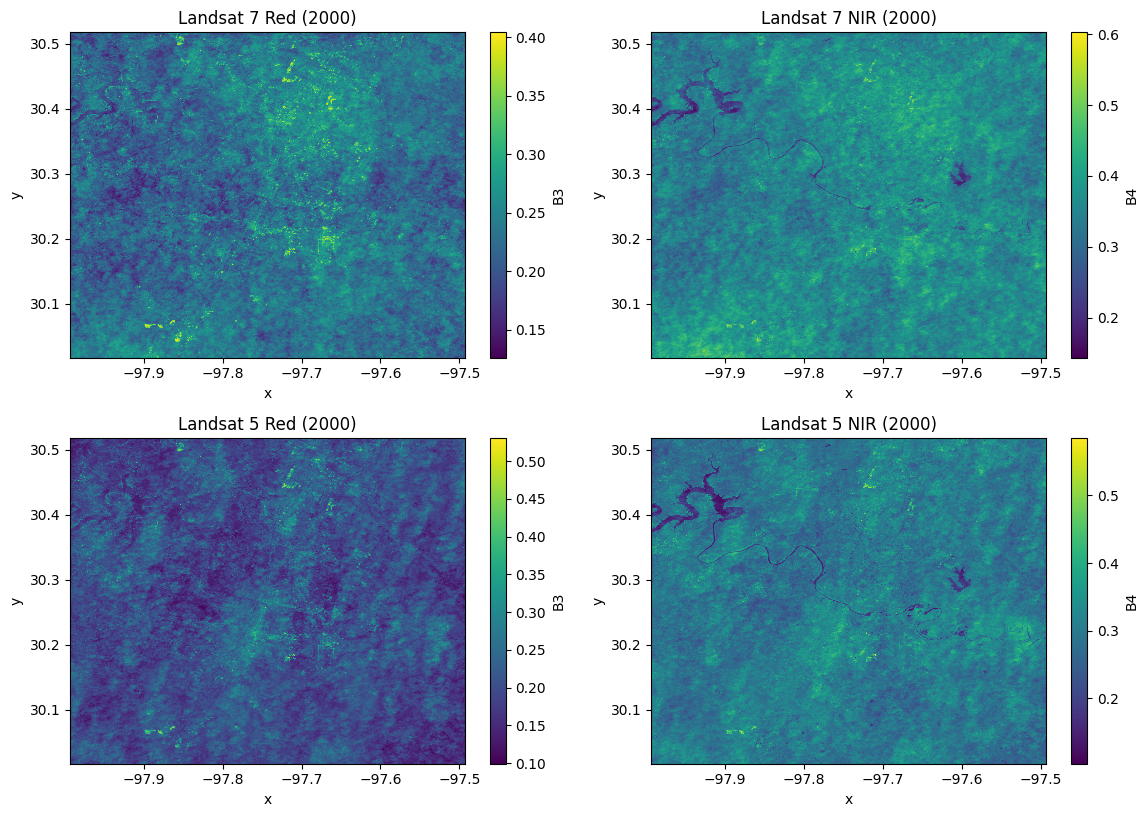

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=2,nrows=2, figsize=(11.69,8.27))
ds_l7_red_2000.B3.plot(ax=ax[0,0])
ds_l7_nir_2000.B4.plot(ax=ax[0,1])
ds_l5_red_2000.B3.plot(ax=ax[1,0])
ds_l5_nir_2000.B4.plot(ax=ax[1,1])
titles = ['Landsat 7 Red (2000)', 'Landsat 7 NIR (2000)', 'Landsat 5 Red (2000)', 'Landsat 5 NIR (2000)']
cnt = 0
for i in range(2):
    for j in range(2):
        ax[i,j].set_title(titles[cnt])
        cnt = cnt + 1
plt.tight_layout()

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)
print(x_train.shape, y_train.shape)

(1857, 1857) (1857, 1857)


In [ ]:
ds_l9_nir

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, x: 1857, y: 1857)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -97.99 -97.99 -97.99 ... -97.49 -97.49 -97.49
  * y            (y) float64 15kB 30.52 30.52 30.52 30.52 ... 30.02 30.02 30.02
    spatial_ref  int64 8B 0
Data variables:
    B5           (time, y, x) float32 14MB 0.3338 0.3338 ... 0.3268 0.3436
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

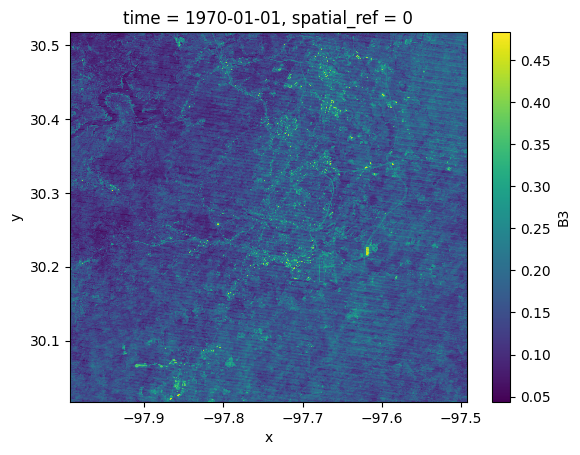

In [ ]:
ds_l7_red.B3.plot()

In [ ]:
ds_l7_red

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, x: 1857, y: 1857)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -97.99 -97.99 -97.99 ... -97.49 -97.49 -97.49
  * y            (y) float64 15kB 30.52 30.52 30.52 30.52 ... 30.02 30.02 30.02
    spatial_ref  int64 8B 0
Data variables:
    B3           (time, y, x) float32 14MB 0.1143 0.1143 0.1128 ... 0.1173 0.12
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
ds_l9_red

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, x: 1857, y: 1857)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -97.99 -97.99 -97.99 ... -97.49 -97.49 -97.49
  * y            (y) float64 15kB 30.52 30.52 30.52 30.52 ... 30.02 30.02 30.02
    spatial_ref  int64 8B 0
Data variables:
    B4           (time, y, x) float32 14MB 0.21 0.21 0.2041 ... 0.1914 0.2048
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
import numpy as np

def unpatchify(patches, img_shape):
    patch_size = patches.shape[1]
    assert patches.shape[0] == (img_shape[0] // patch_size) * (img_shape[1] // patch_size), "Patches and image shape are not compatible"

    img = np.zeros(img_shape, dtype=patches.dtype)
    patch_idx = 0

    for i in range(0, img_shape[0], patch_size):
        for j in range(0, img_shape[1], patch_size):
            img[i:i + patch_size, j:j + patch_size] = patches[patch_idx]
            patch_idx += 1

    return img

def patchify(img, patch_size):
    img_shape = img.shape
    patches = np.array([img[i:i + patch_size, j:j + patch_size] for i in range(0, img_shape[0], patch_size) for j in range(0, img_shape[1], patch_size)])
    return patches

class ncDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets

    def __getitem__(self, index):
        x = torch.from_numpy(self.data[index]).unsqueeze(0)
        y = torch.from_numpy(self.targets[index]).unsqueeze(0)
        # x = self.data[index]
        # y = self.targets[index]
        # x = x.to(dtype=torch.float32)
        # y = y.to(dtype=torch.float32)
        return x, y

    def __len__(self):
        return len(self.data)

# Training for NIR

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)

# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
y_train_patches = patchify(y_train[:1800,:1800], patch_size)

x_val_patches = x_train_patches[3000:3300]
y_val_patches = y_train_patches[3000:3300]

x_test_patches = x_train_patches[3300:3600]
y_test_patches = y_train_patches[3300:3600]

x_train_patches = x_train_patches[:3000]
y_train_patches = y_train_patches[:3000]

In [ ]:
print(x_train_patches.shape, y_train_patches.shape)
from tqdm import tqdm

(3000, 30, 30) (3000, 30, 30)


In [ ]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

from copy import deepcopy

num_epochs = 100
print_interval = 10
patience = 500
best_val_loss = float('inf')
counter = 0
best_model = None

writer = SummaryWriter("runs/swinir")
for epoch in tqdm(range(1, num_epochs + 1)):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

 10%|█         | 10/100 [04:56<44:15, 29.51s/it]

Epoch [10/100] - Train Loss: 0.0029, Validation Loss: 0.0026


 20%|██        | 20/100 [09:51<39:18, 29.49s/it]

Epoch [20/100] - Train Loss: 0.0024, Validation Loss: 0.0026


 30%|███       | 30/100 [14:46<34:28, 29.55s/it]

Epoch [30/100] - Train Loss: 0.0024, Validation Loss: 0.0025


 40%|████      | 40/100 [19:41<29:32, 29.54s/it]

Epoch [40/100] - Train Loss: 0.0022, Validation Loss: 0.0025


 50%|█████     | 50/100 [24:37<24:37, 29.55s/it]

Epoch [50/100] - Train Loss: 0.0022, Validation Loss: 0.0026


 60%|██████    | 60/100 [29:32<19:40, 29.50s/it]

Epoch [60/100] - Train Loss: 0.0024, Validation Loss: 0.0025


 70%|███████   | 70/100 [34:27<14:45, 29.51s/it]

Epoch [70/100] - Train Loss: 0.0021, Validation Loss: 0.0035


 80%|████████  | 80/100 [39:22<09:50, 29.53s/it]

Epoch [80/100] - Train Loss: 0.0020, Validation Loss: 0.0026


 90%|█████████ | 90/100 [44:18<04:55, 29.52s/it]

Epoch [90/100] - Train Loss: 0.0021, Validation Loss: 0.0027


100%|██████████| 100/100 [49:13<00:00, 29.53s/it]

Epoch [100/100] - Train Loss: 0.0019, Validation Loss: 0.0023


In [ ]:
x_train_patches.shape

(3000, 30, 30)

In [ ]:
!ls /content/drive/MyDrive/long_landsat

best_model_swinir_l7_l5_nir.pth  best_model_swinir_l7_l9_red.pth  l7_nir_2000.nc  l7_red.nc
best_model_swinir_l7_l5_red.pth  l5_nir_2000.nc			  l7_nir.nc	  l9_nir.nc
best_model_swinir_l7_l9_nir.pth  l5_red_2000.nc			  l7_red_2000.nc  l9_red.nc


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/long_landsat/best_model_swinir_l7_l9_nir.pth'))
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
reconstructed_predicted_sr.shape

(1800, 1800)

In [ ]:
ds_l7_nir

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, x: 1857, y: 1857)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -97.99 -97.99 -97.99 ... -97.49 -97.49 -97.49
  * y            (y) float64 15kB 30.52 30.52 30.52 30.52 ... 30.02 30.02 30.02
    spatial_ref  int64 8B 0
Data variables:
    B4           (time, y, x) float32 14MB 0.2031 0.2031 ... 0.2202 0.2233
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
# Create the Dataset
ds_pred = xr.Dataset(
    {
        "l7_nir": (["time", "y", "x"], ds_l7_nir.B4.values[:,:1800,:1800])
    },
    coords={
        "time": ds_l7_nir.time.values,
        "x": ds_l7_nir.x.values[:1800],
        "y": ds_l7_nir.y.values[:1800]
    },)

In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

In [ ]:
ds_pred

<xarray.Dataset> Size: 39MB
Dimensions:             (time: 1, y: 1800, x: 1800)
Coordinates:
  * time                (time) datetime64[ns] 8B 1970-01-01
  * x                   (x) float64 14kB -97.99 -97.99 -97.99 ... -97.51 -97.51
  * y                   (y) float64 14kB 30.52 30.52 30.52 ... 30.03 30.03 30.03
Data variables:
    l7_nir              (time, y, x) float32 13MB 0.2031 0.2031 ... 0.2967
    l7_nir_from_l9_nir  (time, y, x) float32 13MB 0.2279 0.2587 ... 0.24 0.2309
    l9_nir              (time, y, x) float32 13MB 0.3338 0.3338 ... 0.331 0.3527

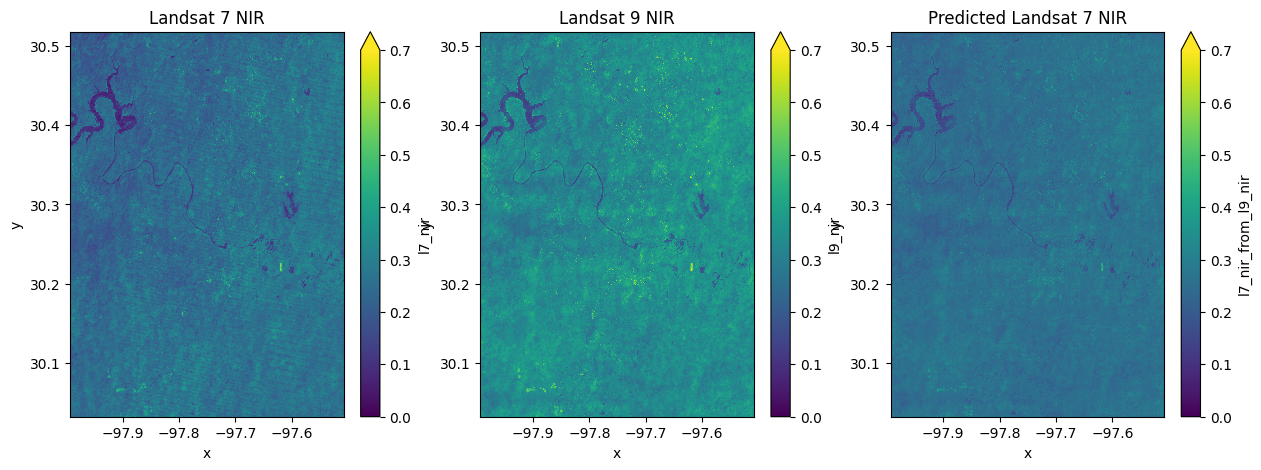

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
ds_pred['l7_nir'].values.max()

0.6183246

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -6.504950346251217 dB


In [ ]:
mse_ = compute_mse(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values)
mse_

1.709732053913942

In [ ]:
10*np.log10(ds_pred['l7_nir'].values.max()*2/mse_)

-1.4068154859185018

In [ ]:
mse_ = compute_mse(ds_pred['l9_nir'].values, ds_pred['l7_nir'].values)
mse_

15.103381029563716

In [ ]:
10*np.log10(ds_pred['l7_nir'].values.max()*2/mse_)

-10.868276736618721

# Training for Red


In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/long_landsat/best_model_swinir_l7_l9_red.pth'))
x_train = ds_l9_red.B4.values[0,:,:].astype(np.float32)
y_train = ds_l7_red.B3.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
# Create the Dataset
ds_pred = xr.Dataset(
    {
        "l7_red": (["time", "y", "x"], ds_l7_red.B3.values[:,:1800,:1800])
    },
    coords={
        "time": ds_l7_red.time.values,
        "x": ds_l7_red.x.values[:1800],
        "y": ds_l7_red.y.values[:1800]
    },)

In [ ]:
ds_pred['l7_red_from_l9_red'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_red'] = (('time', 'y', 'x'), ds_l9_red.B4.values[:,:1800,:1800])

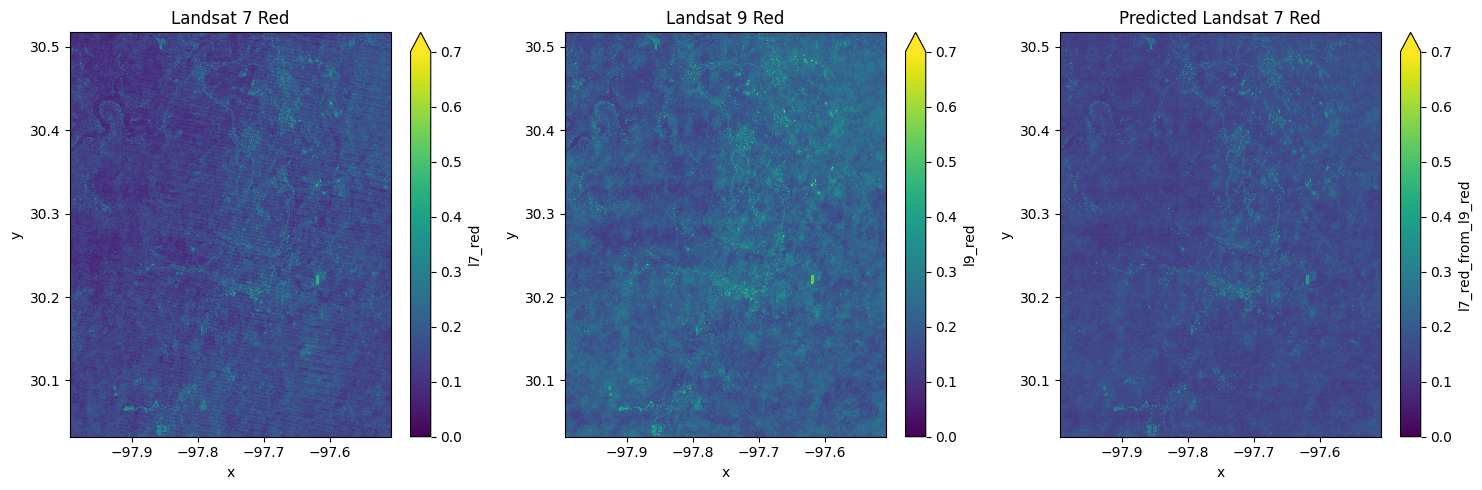

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_red.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_red.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_red_from_l9_red.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 Red', 'Landsat 9 Red', 'Predicted Landsat 7 Red']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])
plt.tight_layout()

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_red_from_l9_red'].values, ds_pred['l7_red'].values, ds_pred['l7_red'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -7.787957092802873 dB


In [ ]:
mse_ = compute_mse(ds_pred['l7_red_from_l9_red'].values, ds_pred['l7_red'].values)
mse_

1.4027298707890135

In [ ]:
10*np.log10(ds_pred['l7_red'].values.max()*2/mse_)

-1.6185488161757935

In [ ]:
mse_ = compute_mse(ds_pred['l9_red'].values, ds_pred['l7_red'].values)
mse_

7.362445382048942

In [ ]:
10*np.log10(ds_pred['l7_red'].values.max()*2/mse_)

-8.819029223488862

# Landsat 5 to Landsat 7

# Red

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/long_landsat/best_model_swinir_l7_l5_red.pth'))
x_train = ds_l5_red_2000.B3.values[0,:,:].astype(np.float32)
y_train = ds_l7_red_2000.B3.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
# Create the Dataset
ds_pred = xr.Dataset(
    {
        "l7_red": (["time", "y", "x"], ds_l7_red_2000.B3.values[:,:1800,:1800])
    },
    coords={
        "time": ds_l7_red_2000.time.values,
        "x": ds_l7_red_2000.x.values[:1800],
        "y": ds_l7_red_2000.y.values[:1800]
    },)

In [ ]:
ds_pred['l7_red_from_l5_red'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l5_red'] = (('time', 'y', 'x'), ds_l5_red_2000.B3.values[:,:1800,:1800])

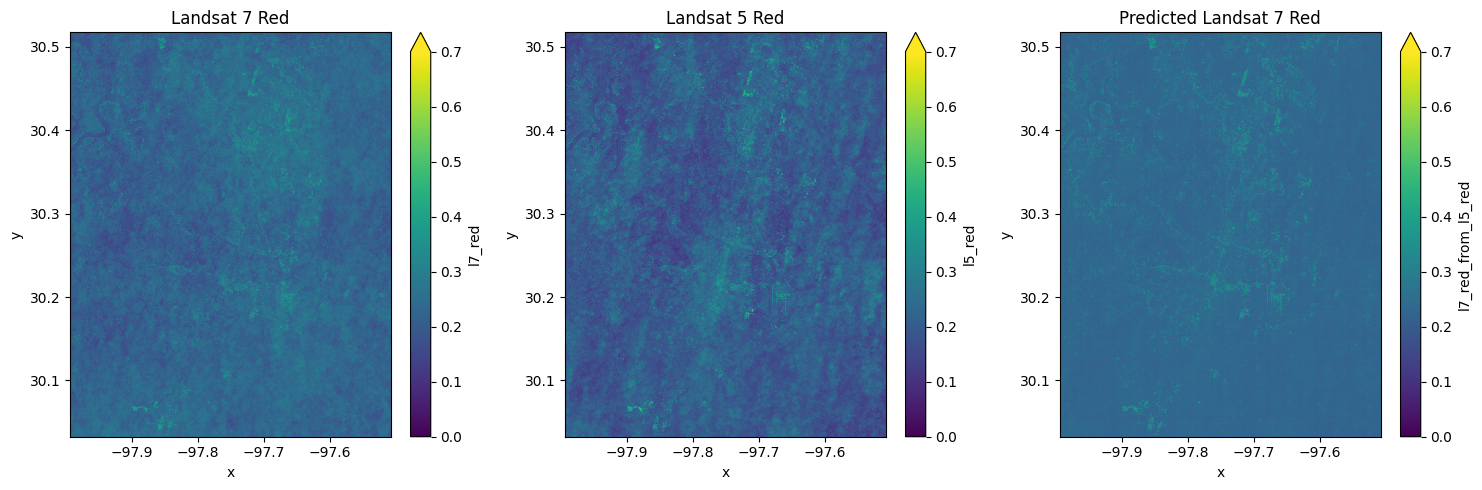

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_red.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l5_red.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_red_from_l5_red.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 Red', 'Landsat 5 Red', 'Predicted Landsat 7 Red']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])
plt.tight_layout()

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_red_from_l5_red'].values, ds_pred['l7_red'].values, ds_pred['l7_red'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -8.244722615162688 dB


# NIR

In [ ]:
model.load_state_dict(torch.load('/content/drive/MyDrive/long_landsat/best_model_swinir_l7_l5_nir.pth'))
x_train = ds_l5_nir_2000.B4.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir_2000.B4.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
# Create the Dataset
ds_pred = xr.Dataset(
    {
        "l7_nir": (["time", "y", "x"], ds_l7_nir_2000.B4.values[:,:1800,:1800])
    },
    coords={
        "time": ds_l7_nir_2000.time.values,
        "x": ds_l7_nir_2000.x.values[:1800],
        "y": ds_l7_nir_2000.y.values[:1800]
    },)

In [ ]:
ds_pred['l7_nir_from_l5_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l5_nir'] = (('time', 'y', 'x'), ds_l5_nir_2000.B4.values[:,:1800,:1800])

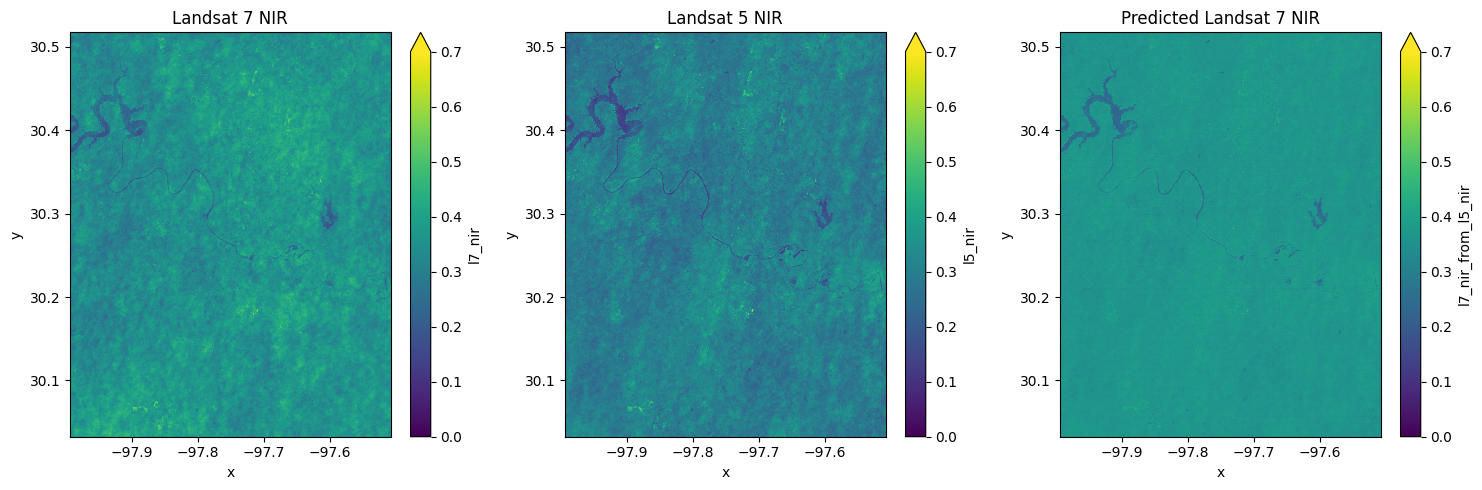

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l5_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l5_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 5 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])
plt.tight_layout()

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l5_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -7.604231198541505 dB


#CARN-M

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        super(ConvBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        return x

class CARNM(nn.Module):
    def __init__(self, num_channels=3, scale_factor=2, num_residual_groups=2, num_residual_blocks=2, num_channels_rg=64):
        super(CARNM, self).__init__()
        self.scale_factor = scale_factor

        self.entry = ConvBlock(num_channels, num_channels_rg, kernel_size=3, stride=1, padding=1)

        self.residual_groups = []
        for _ in range(num_residual_groups):
            rg = []
            for _ in range(num_residual_blocks):
                rg.append(ConvBlock(num_channels_rg, num_channels_rg, kernel_size=3, stride=1, padding=1))
            self.residual_groups.append(nn.Sequential(*rg))

        self.residual_groups = nn.ModuleList(self.residual_groups)
        if scale_factor > 1:
            self.upsample = nn.ConvTranspose2d(num_channels_rg, num_channels_rg, kernel_size=3, stride=scale_factor, padding=1, output_padding=1)
        else:
            self.upsample = None
        self.exit = ConvBlock(num_channels_rg, num_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x = self.entry(x)

        residual_groups = []
        for rg in self.residual_groups:
            residual_groups.append(rg(x))
        x = sum(residual_groups)

        if self.upsample is not None:
            x = self.upsample(x)
        x = self.exit(x)

        return x

#Train Carn-M for NIR

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)

# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
y_train_patches = patchify(y_train[:1800,:1800], patch_size)

x_val_patches = x_train_patches[3000:3300]
y_val_patches = y_train_patches[3000:3300]

x_test_patches = x_train_patches[3300:3600]
y_test_patches = y_train_patches[3300:3600]

x_train_patches = x_train_patches[:3000]
y_train_patches = y_train_patches[:3000]

In [ ]:
print(x_train_patches.shape, y_train_patches.shape)
from tqdm import tqdm

(3000, 30, 30) (3000, 30, 30)


In [ ]:
# Initialize the model, loss function, and optimizer
device = 'cuda'
model = CARNM(num_channels=1, scale_factor=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
train_dataset = ncDataset(x_train_patches, y_train_patches)
val_dataset = ncDataset(x_val_patches, y_val_patches)
test_dataset = ncDataset(x_val_patches, y_val_patches)

train_dataloader = DataLoader(train_dataset, batch_size=20, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=20, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=20, shuffle=True)

In [ ]:
writer = SummaryWriter("runs/carnm")

In [ ]:
from copy import deepcopy

num_epochs = 100
print_interval = 100
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None


for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

Epoch [100/100] - Train Loss: 0.0020, Validation Loss: 0.0029


In [ ]:
model_save_path = "best_model_carnm_nir_l9_to_l7.pth"
torch.save(best_model.state_dict(), model_save_path)

In [ ]:
loaded_model = CARNM(num_channels=1, scale_factor=1).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

CARNM(
  (entry): ConvBlock(
    (conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
  )
  (residual_groups): ModuleList(
    (0-1): 2 x Sequential(
      (0): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
      (1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
      )
    )
  )
  (exit): ConvBlock(
    (conv): Conv2d(64, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
reconstructed_predicted_sr.shape

(1800, 1800)

In [ ]:
ds_l7_nir

<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, x: 1857, y: 1857)
Coordinates:
  * time         (time) datetime64[ns] 8B 1970-01-01
  * x            (x) float64 15kB -97.99 -97.99 -97.99 ... -97.49 -97.49 -97.49
  * y            (y) float64 15kB 30.52 30.52 30.52 30.52 ... 30.02 30.02 30.02
    spatial_ref  int64 8B 0
Data variables:
    B4           (time, y, x) float32 14MB 0.2031 0.2031 ... 0.2202 0.2233
Attributes:
    AREA_OR_POINT:           Area
    TIFFTAG_RESOLUTIONUNIT:  1 (unitless)
    TIFFTAG_XRESOLUTION:     1
    TIFFTAG_YRESOLUTION:     1
    _FillValue:              -32768.0
    scale_factor:            1.0
    add_offset:              0.0

In [ ]:
# Create the Dataset
ds_pred = xr.Dataset(
    {
        "l7_nir": (["time", "y", "x"], ds_l7_nir.B4.values[:,:1800,:1800])
    },
    coords={
        "time": ds_l7_nir.time.values,
        "x": ds_l7_nir.x.values[:1800],
        "y": ds_l7_nir.y.values[:1800]
    },)

In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

In [ ]:
ds_pred

<xarray.Dataset> Size: 39MB
Dimensions:             (time: 1, y: 1800, x: 1800)
Coordinates:
  * time                (time) datetime64[ns] 8B 1970-01-01
  * x                   (x) float64 14kB -97.99 -97.99 -97.99 ... -97.51 -97.51
  * y                   (y) float64 14kB 30.52 30.52 30.52 ... 30.03 30.03 30.03
Data variables:
    l7_nir              (time, y, x) float32 13MB 0.2031 0.2031 ... 0.2967
    l7_nir_from_l9_nir  (time, y, x) float32 13MB 0.2528 0.2513 ... 0.2586
    l9_nir              (time, y, x) float32 13MB 0.3338 0.3338 ... 0.331 0.3527

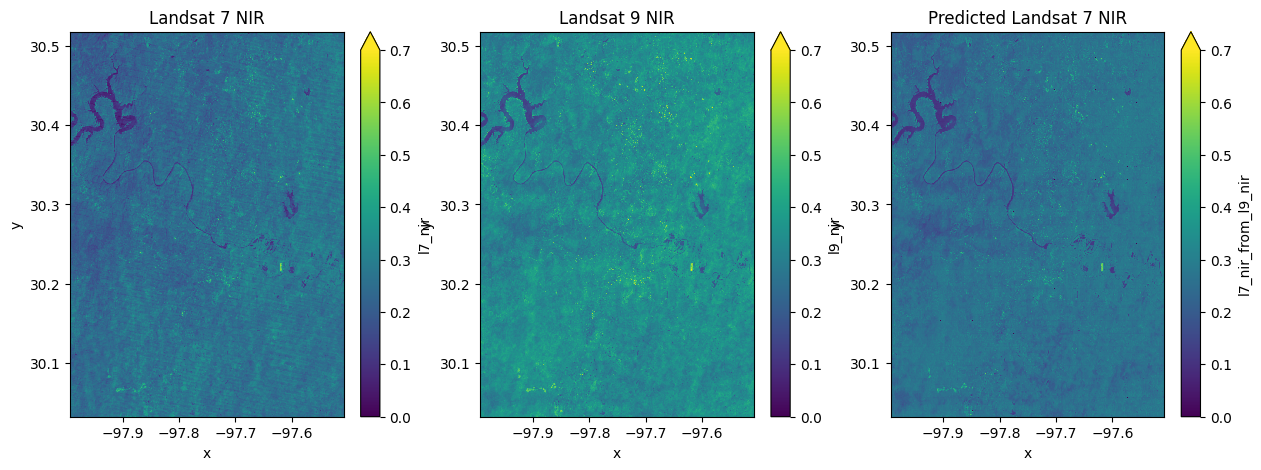

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
ds_pred['l7_nir'].values.max()

0.6183246

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -6.038917683006719 dB


#DLGSCA

In [ ]:
class CALayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super(CALayer, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.c1 = nn.Conv2d(channel, channel // reduction, 1, padding=0)
        self.c2 = nn.Conv2d(channel // reduction, channel, 1, padding=0)

    def forward(self, x):
        y = self.avg_pool(x)
        y = self.c1(y)
        y = nn.ReLU()(y)
        y = self.c2(y)
        return nn.Sigmoid()(y) * x

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(Block, self).__init__()
        self.c1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        self.c2 = nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding)
        self.relu = nn.ReLU(inplace=True)
        self.ca = CALayer(out_channels)

    def forward(self, x):
        h0 = self.relu(self.c1(x))
        h1 = self.c2(h0)
        h1 = self.ca(h1)
        return h1

class DLGSANet(nn.Module):
    def __init__(self, in_channels, upscale_factor):
        super(DLGSANet, self).__init__()

        self.input_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)

        self.blocks = nn.Sequential(
            Block(64, 64),
            Block(64, 64),
            Block(64, 64),
            Block(64, 64)
        )

        self.output_conv = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.relu(self.input_conv(x))

        x2 = self.blocks(x1)

        x3 = self.output_conv(x2)
        return x + x3

In [ ]:
# Create the DLGSANet model
in_channels = 1
upscale_factor = 1
model = DLGSANet(in_channels, upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
writer = SummaryWriter("runs/DLGSANet")

In [ ]:
from copy import deepcopy

num_epochs = 100
print_interval = 100
patience = 1000
best_val_loss = float('inf')
counter = 0
best_model = None


for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

Epoch [100/100] - Train Loss: 0.0023, Validation Loss: 0.0035


In [ ]:
model_save_path = "best_model_DLGSANet_NIR_L7_from_l9.pth"
torch.save(best_model.state_dict(), model_save_path)

In [ ]:
loaded_model = DLGSANet(in_channels, upscale_factor).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

DLGSANet(
  (input_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu): ReLU(inplace=True)
  (blocks): Sequential(
    (0): Block(
      (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (ca): CALayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (c1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (c2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): Block(
      (c1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (c2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu): ReLU(inplace=True)
      (ca): CALayer(
        (avg_pool): AdaptiveAvgPool2d(output_size=1)
        (c1): Conv2d(64, 4, kernel_size=(1, 1), stride=(1, 1))
        (c2): Conv2d(4, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (2): Block(
  

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

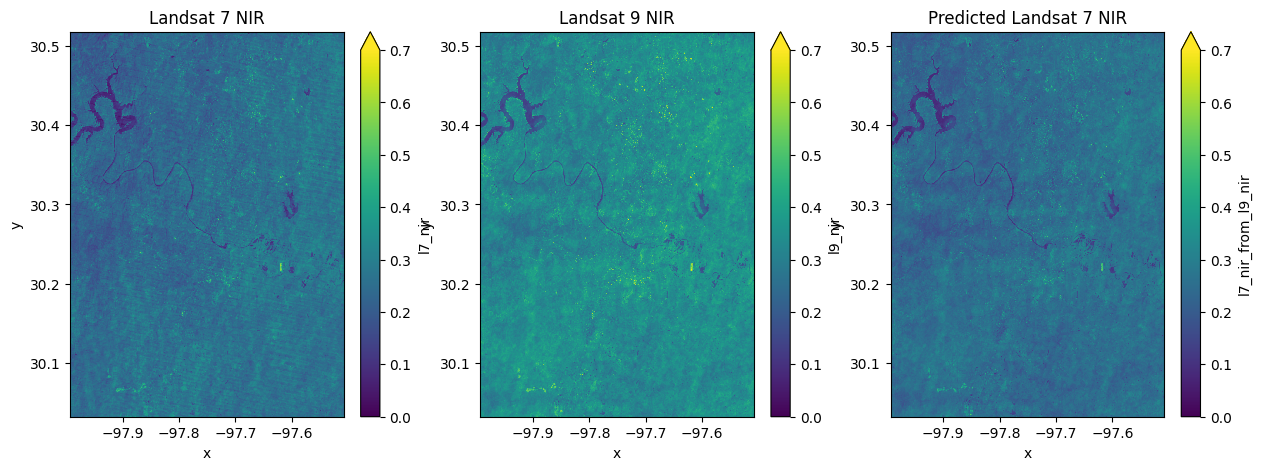

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -6.493612925646307 dB


#FSRCNN

In [ ]:
class FSRCNN(nn.Module):
    def __init__(self, d=56, s=12, m=4, upscale_factor=1):
        super(FSRCNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(1, d, kernel_size=5, padding=5//2),
            nn.PReLU(d)
        )

        self.mid_parts = [nn.Sequential(
            nn.Conv2d(d, s, kernel_size=1),
            nn.PReLU(s)
        )]

        for _ in range(m - 1):
            self.mid_parts.append(nn.Sequential(
                nn.Conv2d(s, s, kernel_size=3, padding=3//2),
                nn.PReLU(s)
            ))

        self.mid_parts = nn.Sequential(*self.mid_parts)

        self.last_part = nn.Sequential(
            nn.Conv2d(s, d, kernel_size=1),
            nn.PReLU(d),
            nn.ConvTranspose2d(d, 1, kernel_size=9, stride=upscale_factor, padding=9//2, output_padding=upscale_factor-1)
        )

    def forward(self, x):
        x = self.first_part(x)
        x = self.mid_parts(x)
        x = self.last_part(x)
        return x

In [ ]:
# Initialize the model, loss function, and optimizer
device = 'cuda'
model = FSRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
writer = SummaryWriter("runs/fsrcnn")

In [ ]:
from copy import deepcopy

num_epochs = 100
print_interval = 100
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None


for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

Early stopping triggered.


In [ ]:
model_save_path = "best_model_fsrcnn_l9_from_l7.pth"
torch.save(best_model.state_dict(), model_save_path)

In [ ]:
loaded_model = FSRCNN().to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

FSRCNN(
  (first_part): Sequential(
    (0): Conv2d(1, 56, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): PReLU(num_parameters=56)
  )
  (mid_parts): Sequential(
    (0): Sequential(
      (0): Conv2d(56, 12, kernel_size=(1, 1), stride=(1, 1))
      (1): PReLU(num_parameters=12)
    )
    (1): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=12)
    )
    (2): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=12)
    )
    (3): Sequential(
      (0): Conv2d(12, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): PReLU(num_parameters=12)
    )
  )
  (last_part): Sequential(
    (0): Conv2d(12, 56, kernel_size=(1, 1), stride=(1, 1))
    (1): PReLU(num_parameters=56)
    (2): ConvTranspose2d(56, 1, kernel_size=(9, 9), stride=(1, 1), padding=(4, 4))
  )
)

In [ ]:
x_train = ds_l9_nir.B5.values[0,:,:].astype(np.float32)
y_train = ds_l7_nir.B4.values[0,:,:].astype(np.float32)
img = x_train[:1800,:1800]
# Create patches from the image
patch_size = 30
# x_img = x_train[:1800,:1800]
# y_img = y_train[:1800,:1800]
# x_patches = patchify(x_img, patch_size)
# y_patches = patchify(y_img, patch_size)

x_train_max = x_train.max()
y_train_max = y_train.max()
x_train /= x_train_max
y_train /= y_train_max

x_train_patches = patchify(x_train[:1800,:1800], patch_size)
x_train_patches_tensor = torch.from_numpy(x_train_patches).to(device)
x_train_patches_tensor = x_train_patches_tensor.unsqueeze(1)  # Adds a channel dimension, resulting in [3600, 1, 30, 30]
with torch.no_grad():
    predicted_sr = model(x_train_patches_tensor)
predicted_sr_np = predicted_sr.cpu().numpy() * y_train_max
predicted_sr_np[predicted_sr_np<0] = 0.0
reconstructed_predicted_sr = unpatchify(predicted_sr_np[:,0,:,:], img.shape)

In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

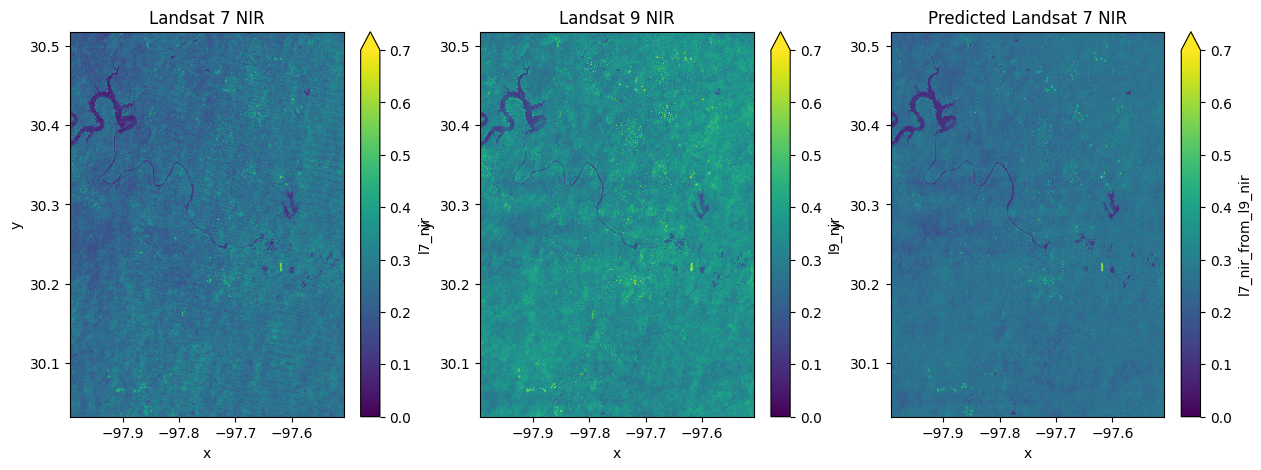

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -5.972335247033015 dB


#LapSRN

In [ ]:
class LapSRN(nn.Module):
    def __init__(self, in_channels=1, upscale_factor=1):
        super(LapSRN, self).__init__()

        self.upscale_factor = upscale_factor
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.LeakyReLU(0.2)

        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.LeakyReLU(0.2)

        self.conv3 = nn.Conv2d(64, in_channels * (upscale_factor ** 2), kernel_size=3, stride=1, padding=1)

        if upscale_factor > 1:
            self.pixel_shuffle = nn.PixelShuffle(upscale_factor)
        else:
            self.pixel_shuffle = None

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.relu2(self.conv2(x))
        x = self.conv3(x)

        if self.pixel_shuffle is not None:
            x = self.pixel_shuffle(x)

        return x

In [ ]:
# Initialize the model, loss function, and optimizer
device = 'cuda'
model = LapSRN(in_channels=1, upscale_factor=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
writer = SummaryWriter("runs/lapsr")

In [ ]:
from copy import deepcopy

num_epochs = 10000
print_interval = 100
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None


for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

Early stopping triggered.


In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

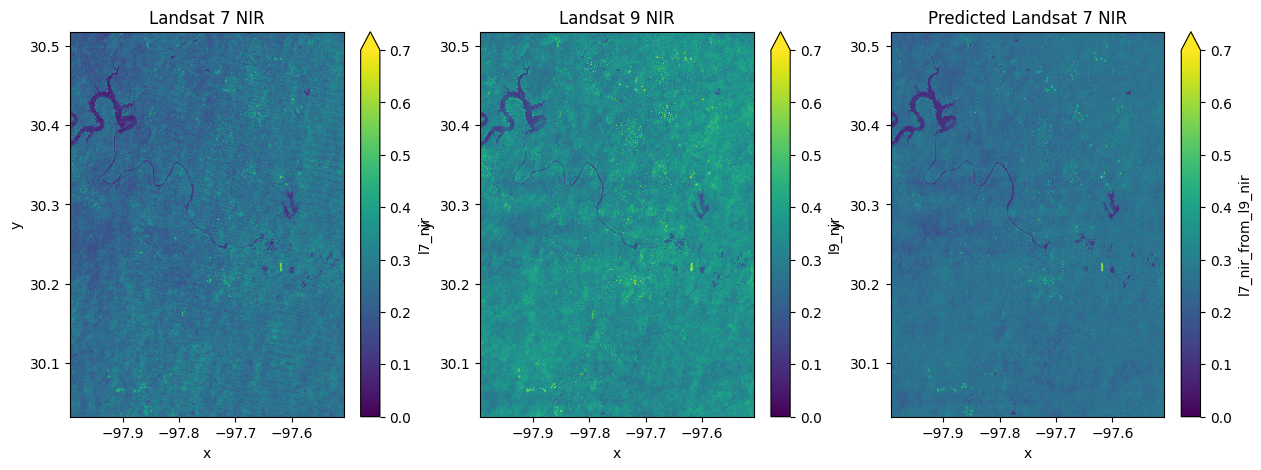

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")

PSNR: -5.972335247033015 dB


#RCAN

In [ ]:

class ResidualChannelAttentionBlock(nn.Module):
    def __init__(self, n_feat, kernel_size=3, reduction=16, bias=True, bn=False, act=nn.ReLU(True), res_scale=1):
        super(ResidualChannelAttentionBlock, self).__init__()
        modules_body = []
        for _ in range(2):
            modules_body.append(nn.Conv2d(n_feat, n_feat, kernel_size, padding=1, bias=bias))
            if bn: modules_body.append(nn.BatchNorm2d(n_feat))
            modules_body.append(act)
        modules_body.pop() # remove last activation
        self.body = nn.Sequential(*modules_body)
        # channel attention
        self.ca = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Conv2d(n_feat, n_feat // reduction, 1, padding=0, bias=bias),
            act,
            nn.Conv2d(n_feat // reduction, n_feat, 1, padding=0, bias=bias),
            nn.Sigmoid()
        )
        self.res_scale = res_scale

    def forward(self, x):
        res = self.body(x)
        res = self.ca(res) * res
        res += x
        return res

class RCAN(nn.Module):
    def __init__(self, in_channels, num_blocks, upscale_factor):
        super(RCAN, self).__init__()

        self.input_conv = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.prelu = nn.PReLU()

        self.residual_blocks = nn.Sequential(
            *[ResidualChannelAttentionBlock(64) for _ in range(num_blocks)]
        )

        self.output_conv = nn.Conv2d(64, in_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x1 = self.input_conv(x)
        x1 = self.prelu(x1)

        x2 = self.residual_blocks(x1)

        x3 = self.output_conv(x2)
        return x + x3

In [ ]:
# Create the RCAN model
in_channels = 1
upscale_factor = 1
num_blocks = 16
model = RCAN(in_channels, num_blocks, upscale_factor).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
writer = SummaryWriter("runs/rcan")

In [ ]:
from copy import deepcopy

num_epochs = 100
print_interval = 100
patience = 50
best_val_loss = float('inf')
counter = 0
best_model = None


for epoch in range(1, num_epochs + 1):
    train_loss, val_loss = train(model, train_dataloader, val_dataloader, criterion, optimizer, device)
# Log losses to TensorBoard
    writer.add_scalars("Loss", {"Train": train_loss, "Validation": val_loss}, epoch)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model = deepcopy(model)
        counter = 0
    else:
        counter += 1

    if epoch % print_interval == 0:
        print(f"Epoch [{epoch}/{num_epochs}] - Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

    if counter >= patience:
        print("Early stopping triggered.")
        break
writer.close()

In [ ]:
model_save_path = "best_model_rcan.pth"
torch.save(best_model.state_dict(), model_save_path)

In [ ]:
loaded_model = RCAN(in_channels, num_blocks, upscale_factor).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()

In [ ]:
ds_pred['l7_nir_from_l9_nir'] = (('time', 'y', 'x'), reconstructed_predicted_sr[np.newaxis,:,:])
ds_pred['l9_nir'] = (('time', 'y', 'x'), ds_l9_nir.B5.values[:,:1800,:1800])

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(ncols=3,nrows=1, figsize=(15,5))
ds_pred.l7_nir.plot(ax=ax[0], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l9_nir.plot(ax=ax[1], vmin=0.0, vmax=0.7, extend='max')
ds_pred.l7_nir_from_l9_nir.plot(ax=ax[2], vmin=0.0, vmax=0.7, extend='max')
titles = ['Landsat 7 NIR', 'Landsat 9 NIR', 'Predicted Landsat 7 NIR']
for i,ax_ in enumerate(ax):
    ax_.set_title(titles[i])

In [ ]:
import numpy as np

def compute_mse(imageA, imageB):
    """Compute the Mean Squared Error between two images."""
    err = np.sum((imageA.astype("float") - imageB.astype("float")) ** 2)
    err /= float(imageA.shape[0] * imageA.shape[1])
    return err

def compute_psnr(imageA, imageB, max_pixel_value):
    """Compute the PSNR between two images."""
    mse = compute_mse(imageA, imageB)

    # Avoid division by zero
    if mse == 0:
        return float('inf')

    return 10 * np.log10(max_pixel_value**2 / mse)

# Example usage:
# original = np.random.randint(0, 256, (512, 512), dtype=np.uint8)  # Random original image
# compressed = original + np.random.randint(-10, 10, (512, 512), dtype=np.int16)  # Simulated compressed image
# compressed = np.clip(compressed, 0, 255).astype(np.uint8)

psnr_value = compute_psnr(ds_pred['l7_nir_from_l9_nir'].values, ds_pred['l7_nir'].values, ds_pred['l7_nir'].values.max())
print(f"PSNR: {psnr_value} dB")